# COMP4030 - Data Science and Machine Learning - Coursework 2

Firstly we ensure that the raw data provided by Phyphox is unzipped and ready for import.

In [1]:
import os

def get_gestures():
      return ['circle', 'come', 'go', 'wave']

def get_columns():
    return ['time', 'accel_x', 'accel_y', 'accel_z', 'accel_abs']

def get_gesture_csvs(gesture):
      gesture_dir = os.path.join(os.getcwd(), "data", gesture)
      return [file for file in os.listdir(gesture_dir) if file.endswith('.csv')]

Next we read the raw data from the CSV files and place the data inside a pandas DataFrame. We also use this opportunity to normalise our data using a MinMaxScaler, ensuring that all of our data lies between 0 and 1. This will ensure that no single field plays a more important role than it should.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def get_data_from_files(scaler=None):
      dfs = []
      for gesture in get_gestures():
            for file_index, file_name in enumerate(get_gesture_csvs(gesture)):
                  data = pd.read_csv(f'data/{gesture}/{file_name}')
                  data.columns = get_columns()

                  if scaler:
                        scaled_features = scaler.fit_transform(data)
                  else:
                        scaled_features = data
                        
                  df = pd.DataFrame(scaled_features, columns=data.columns)
                  df['file_number'] = int(file_index)
                  df['gesture'] = str(gesture)

                  dfs.append(df)

      if len(dfs) > 1:
            df = pd.concat(dfs, ignore_index=True)
      else:
            df = dfs[0]

      return df

# scaler = StandardScaler()
scaler = MinMaxScaler()
df = get_data_from_files(scaler)
df

,time,accel_x,accel_y,accel_z,accel_abs,file_number,gesture
0,0.000000,0.571972,0.557543,0.202179,0.076508,0,circle
1,0.000717,0.578471,0.543073,0.185550,0.093676,0,circle
2,0.001435,0.576779,0.546803,0.208412,0.083951,0,circle
3,0.002154,0.556248,0.552712,0.218944,0.057660,0,circle
4,0.002872,0.531502,0.537858,0.215333,0.046234,0,circle
...,...,...,...,...,...,...,...
138308,0.997635,0.524061,0.894023,0.593876,0.008317,13,wave
138309,0.998226,0.524200,0.898578,0.592472,0.006793,13,wave
138310,0.998817,0.525156,0.901629,0.593683,0.007344,13,wave
138311,0.999409,0.526857,0.905139,0.593781,0.009465,13,wave


Next we visualise our raw data for exploratory analysis

In [3]:
SHOW_RAW_DATA = False

In [4]:
import math
import matplotlib.pyplot as plt

if SHOW_RAW_DATA:
      for gesture in get_gestures():
            
            group = df[df['gesture'] == gesture].groupby('file_number')
            
            if len(group) == 0:
                  continue

            cols = 2
            rows = math.ceil(len(group) / cols)
            plt.figure(figsize=(cols * 15, rows * 3))

            for index, df_group in enumerate(group):
                  plt.subplot(rows, cols, index + 1)
                  for col in get_columns()[1:]:
                        plt.plot(df_group[1].index, df_group[1][col], label=col)
                        plt.xticks(range(df_group[1].index[0], df_group[1].index[-1], 50))
                        plt.legend()
            plt.suptitle(gesture)
            plt.show()

We then try to segment this data, using the dips in acceleration that we had purposefully included in our data captures.

Firstly we visualise just one example to inspect the rolling standard deviation and attempt to find the optimal parameters for slicing our data.

In [5]:
rolling_window = 10
group_threshold = 10
deviation_threshold = 1.7

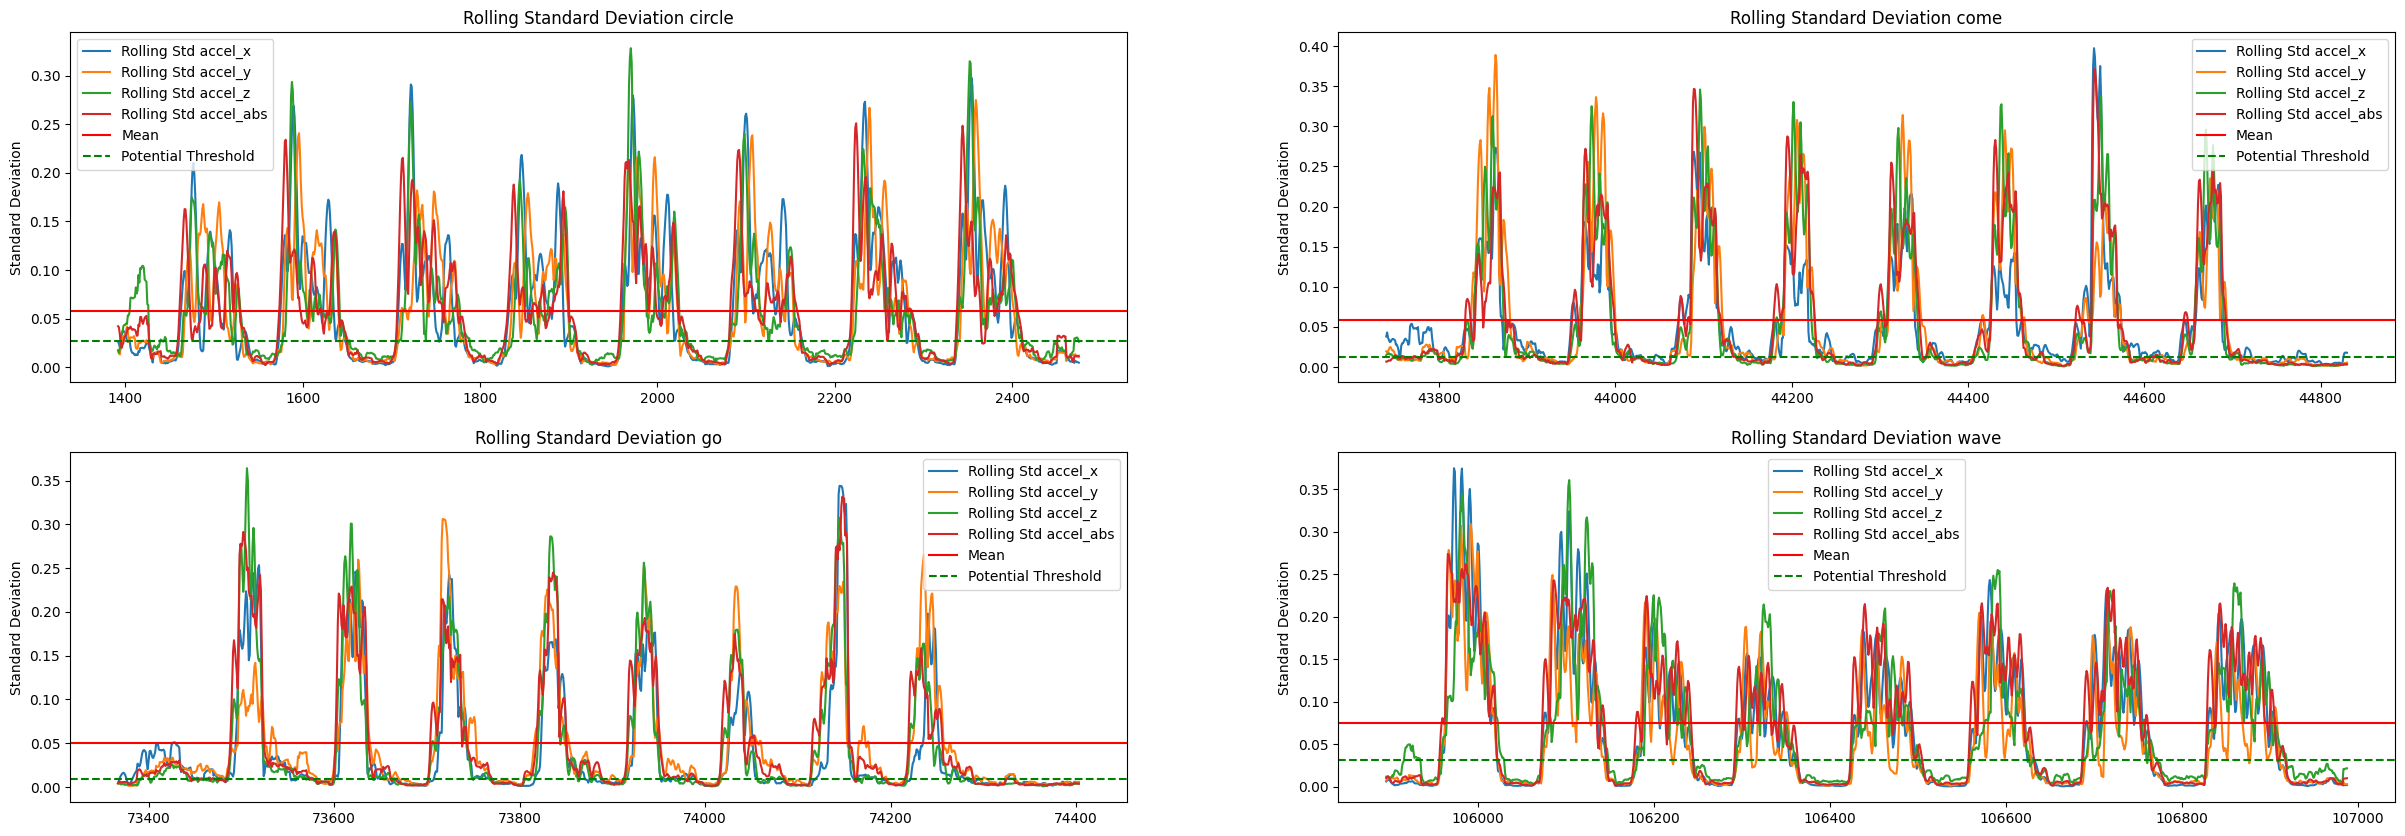

In [6]:
plt.figure(figsize=(30, 10))

for file_index, gesture in enumerate(get_gestures()):

      group = df[(df['gesture'] == gesture) & (df['file_number'] == 1)]
      if len(group) == 0:
            continue

      rolling_std = group['accel_abs'].rolling(window=rolling_window).std()
      drop_all_below = rolling_std.mean() - rolling_std.std() / deviation_threshold

      plt.subplot(2, 2, file_index + 1)

      for col in get_columns()[1:]:
            plt.plot(group[col].rolling(window=rolling_window).std(), label=f'Rolling Std {col}')

      plt.axhline(y=rolling_std.mean(), color='r', linestyle='-', label='Mean')
      plt.axhline(y=drop_all_below, color='g', linestyle='--', label='Potential Threshold')    
      plt.title(f'Rolling Standard Deviation {gesture}')
      plt.ylabel('Standard Deviation')
      plt.legend()

plt.show()

In [7]:
def cluster_and_average_points(integers, cluster_range=50):
      clusters = []
      current_cluster = [integers[0]]

      for number in integers[1:]:
            if number - current_cluster[-1] <= cluster_range:
                  current_cluster.append(number)
            else:
                  clusters.append(current_cluster)
                  current_cluster = [number]
      
      if current_cluster:
            clusters.append(current_cluster)
      
      return [sum(cluster) // len(cluster) for cluster in clusters]

def get_indices_below_threshold(data, rolling_window, group_threshold, deviation_threshold):
      
      rolling_std = data['accel_abs'].rolling(window=rolling_window).std()
      threshold = rolling_std.mean() - rolling_std.std() / deviation_threshold

      return rolling_std[(rolling_std.shift(-group_threshold) < threshold) & (rolling_std.shift(group_threshold) < threshold)].index

Then we visualise our slices for all of the data.

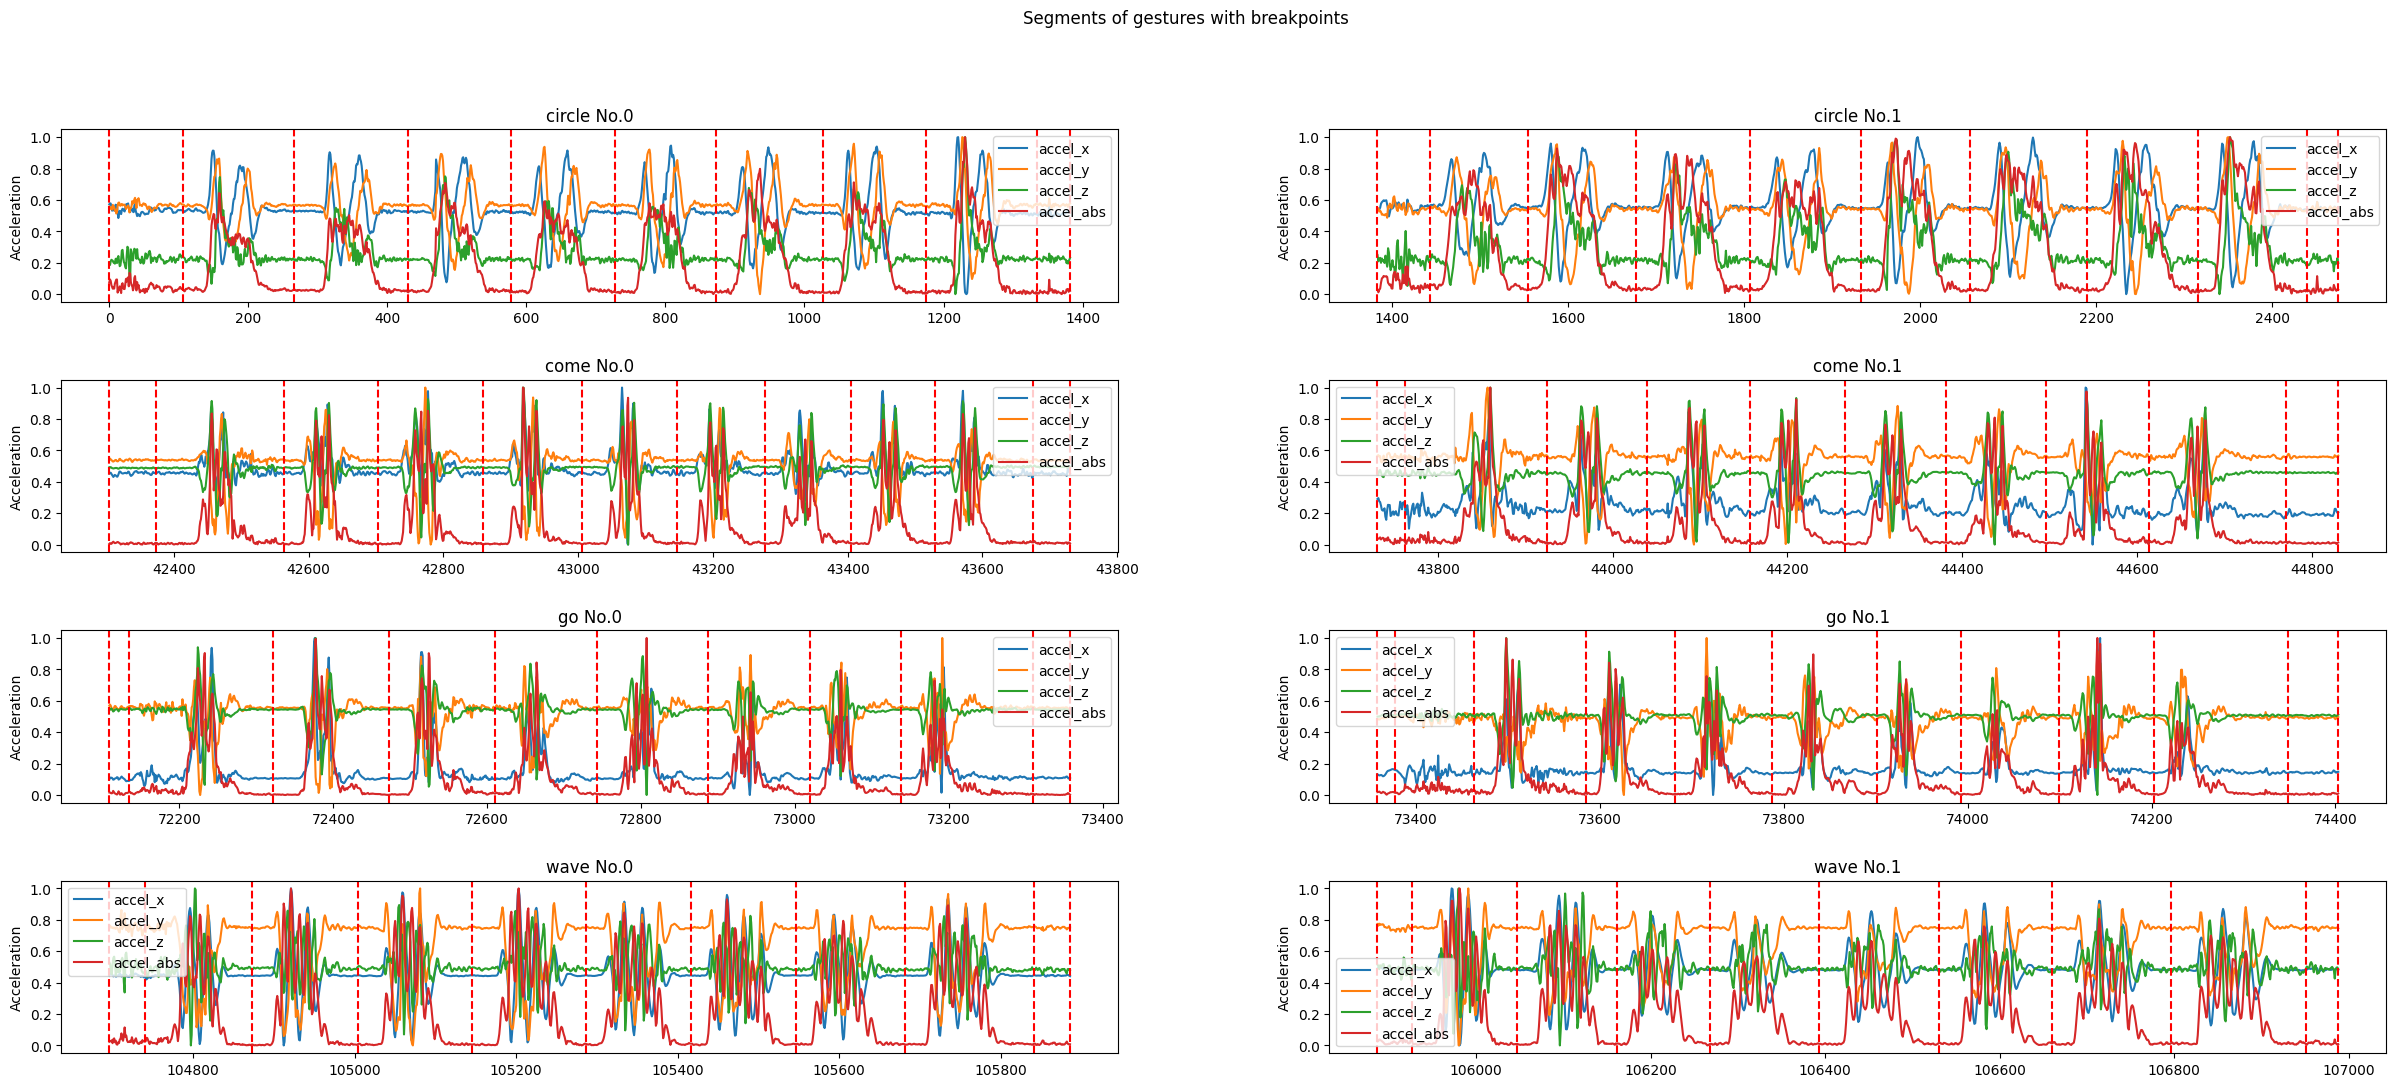

In [8]:
plt.figure(figsize=(30, 12))
plot = 1
for gesture in get_gestures():
    feature = df[df['gesture'] == gesture]
    for file_index, sub_group in feature.groupby('file_number'):

        indices_below_threshold = get_indices_below_threshold(sub_group, rolling_window, group_threshold, deviation_threshold)
        breakpoints = cluster_and_average_points(indices_below_threshold, 25)
        breakpoints.append(sub_group.index[-1])
        breakpoints.append(sub_group.index[0])

        if file_index > 1:
            break

        plt.subplot(4, 2, plot)
        plot += 1

        for col in get_columns()[1:]:
            plt.plot(sub_group.index, sub_group[col], label=col)

        for index in breakpoints:
            plt.axvline(x=index, color='r', linestyle='--')

        plt.ylabel('Acceleration')
        plt.title(f'{gesture} No.{file_index}')
        plt.legend()
        plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

We can safely remove the data where the absolute acceleration never gets above a certain threshold.

In [9]:
def apply_segmentation_and_geture_numbering(df, drop_all_below, short_segment_threshold):
            
      indices_to_drop = []
      gesture_number = 1

      for i, sub_group in df.groupby(['file_number', 'gesture']):

            indices_below_threshold = get_indices_below_threshold(sub_group, rolling_window, group_threshold, deviation_threshold)
            breakpoints = cluster_and_average_points(indices_below_threshold, 25)

            breakpoints.insert(0, sub_group.index[0])
            breakpoints.append(sub_group.index[-1])

            for b in range(len(breakpoints) - 1):
                  segment = df.loc[breakpoints[b]:breakpoints[b+ 1]]['accel_abs']
                  all_below_threshold = (segment < drop_all_below).all()
                  if all_below_threshold or len(segment) < short_segment_threshold:
                        dropping = range(breakpoints[b], breakpoints[b + 1])
                        indices_to_drop += dropping
                  else:
                        df.loc[breakpoints[b]:breakpoints[b + 1], 'gesture_number'] = int(gesture_number)
                        gesture_number += 1

      df.drop(indices_to_drop, inplace=True)
      df.dropna(subset=['gesture_number'], inplace=True)
      df.reset_index(drop=True, inplace=True)


def number_to_color(number):    
    normalized_number = (number - 1) / (100 - 1)
    colormap = plt.cm.viridis
    color = colormap(normalized_number)
    
    return color

In [10]:
## Apply segmentation and clearing of invalid gestures
apply_segmentation_and_geture_numbering(df, drop_all_below = 0.3, short_segment_threshold = 50)

In [11]:
df

,time,accel_x,accel_y,accel_z,accel_abs,file_number,gesture,gesture_number
0,0.076094,0.533846,0.570389,0.238792,0.032600,0,circle,1.0
1,0.076812,0.527632,0.569774,0.233160,0.023704,0,circle,1.0
2,0.077530,0.523436,0.564875,0.230934,0.018012,0,circle,1.0
3,0.078248,0.525716,0.559592,0.223312,0.020920,0,circle,1.0
4,0.078966,0.530688,0.557723,0.203405,0.032933,0,circle,1.0
...,...,...,...,...,...,...,...,...
117372,0.968066,0.531121,0.909114,0.600040,0.017621,13,wave,515.0
117373,0.968658,0.526757,0.905200,0.604843,0.013416,13,wave,515.0
117374,0.969249,0.522737,0.903904,0.610654,0.014461,13,wave,515.0
117375,0.969840,0.521787,0.901869,0.609714,0.013779,13,wave,515.0


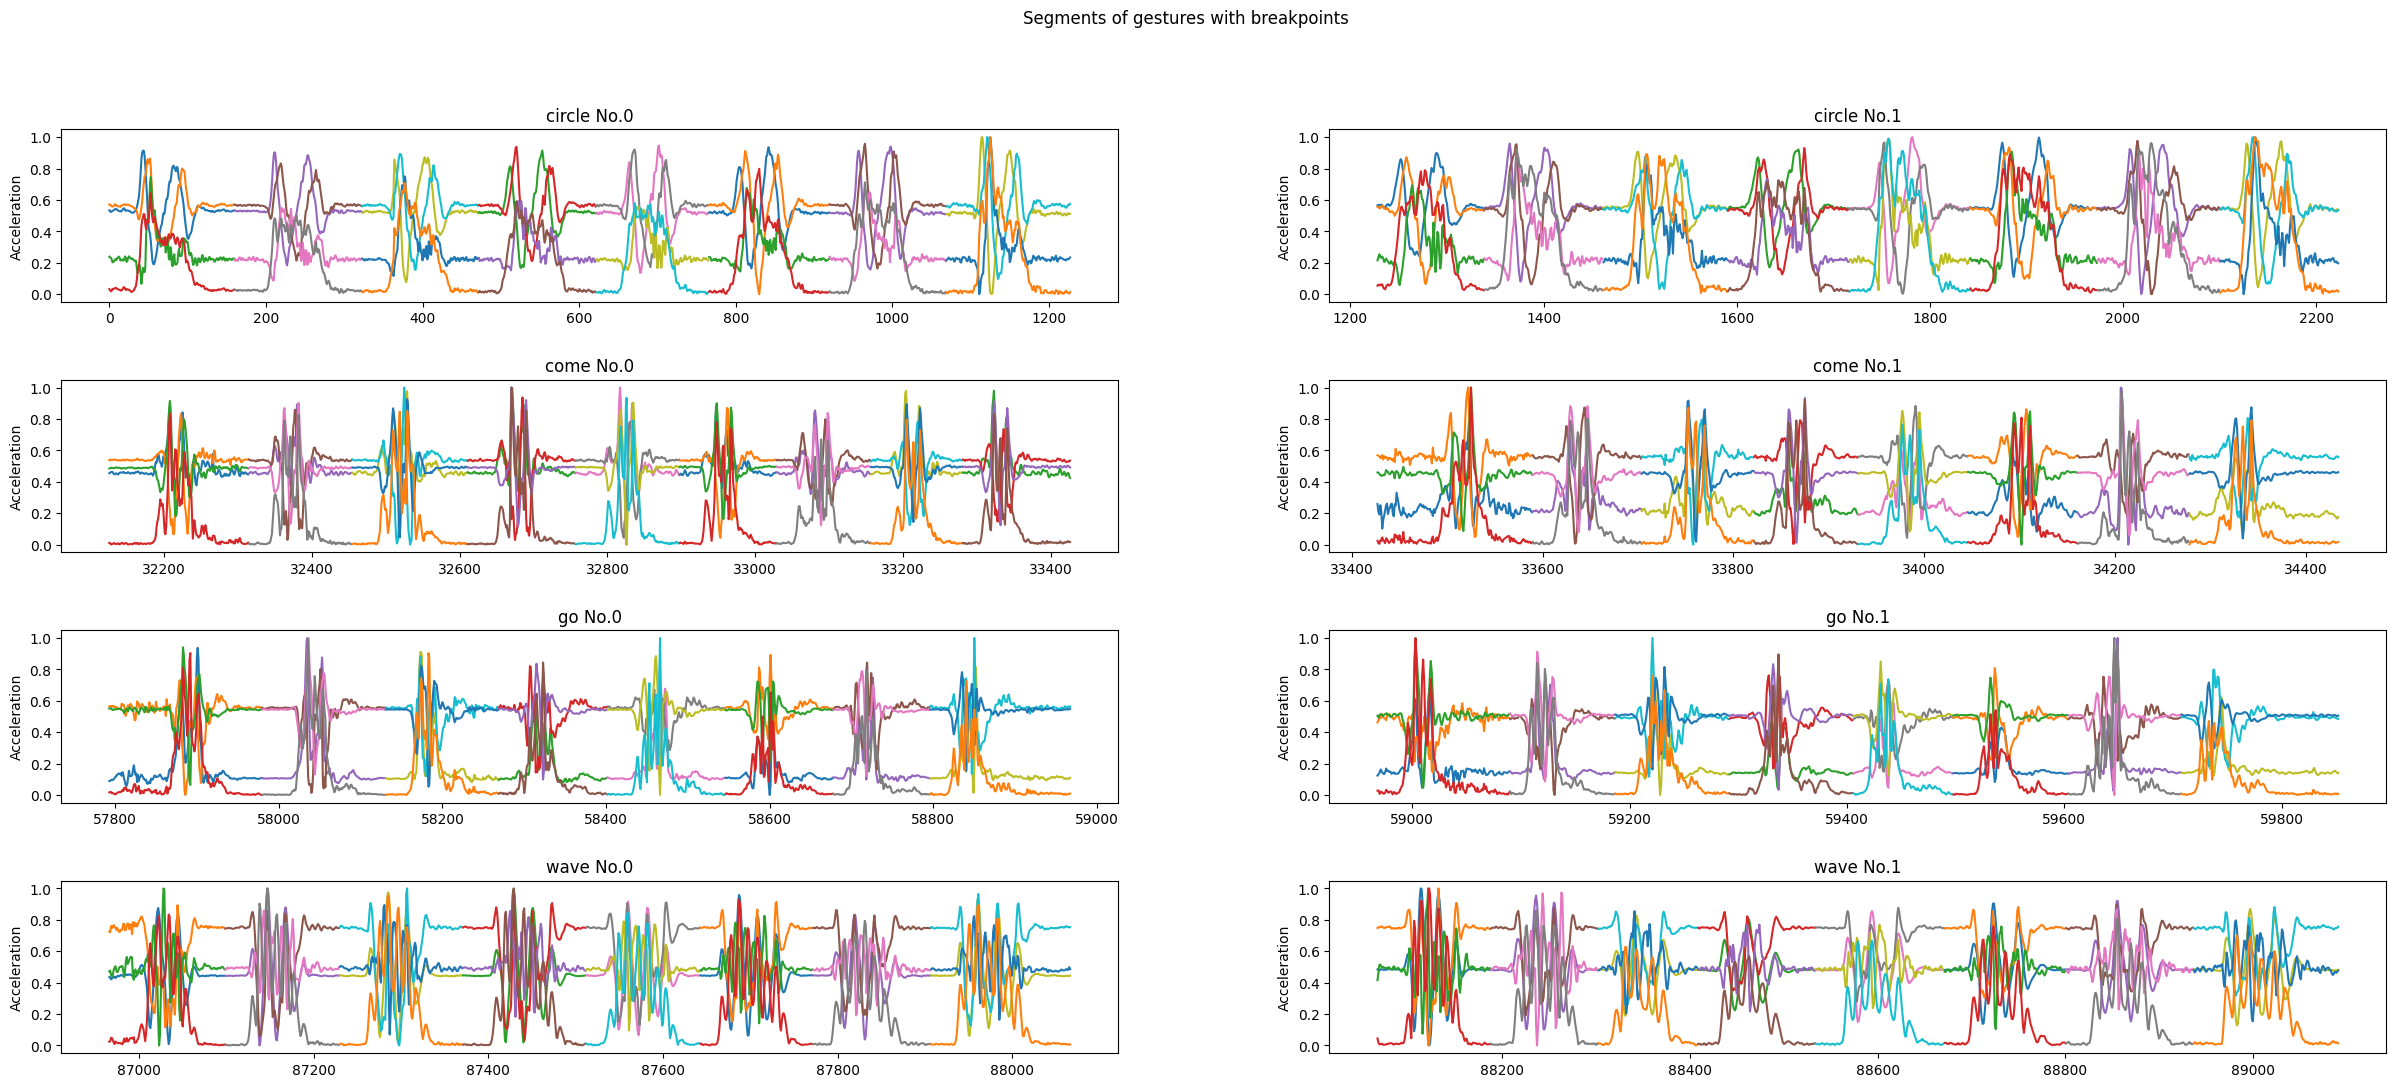

In [12]:
plt.figure(figsize=(30, 12))
plot = 1
for gesture in get_gestures():
    feature = df[df['gesture'] == gesture]
    for file_index, sub_group in feature.groupby('file_number'):

        if file_index > 1: ## only show the first two files
            break

        plt.subplot(4, 2, plot)
        plot += 1

        for gesture_number in sub_group['gesture_number'].unique():
            gesture_group = sub_group[sub_group['gesture_number'] == gesture_number]        
            # plt.plot(gesture_group.index, gesture_group['accel_abs'], label=number_to_color(gesture))
        
            for col in get_columns()[1:]:
                plt.plot(gesture_group.index, gesture_group[col], label=number_to_color(gesture_number))

        plt.ylabel('Acceleration')
        plt.title(f'{gesture} No.{file_index}')
        plt.subplots_adjust(hspace=0.45)
    
plt.suptitle("Segments of gestures with breakpoints")
plt.show()

Now we double check that the data does not contain these filtered out data segments that do not represent a gesture

In [13]:
## Check we no longer have segments that are very short or have very low acceleration
for label, group in df.groupby(['gesture', 'gesture_number']):
      if(group.shape[0] < 50):
            data = df[(df['gesture'] == label[0]) & (df['gesture_number'] == label[1])]
            print(label, data['file_number'].unique(), data['gesture_number'].unique(), data['accel_abs'].max())

In [14]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(labels):
    encoder = LabelEncoder()
    return encoder.fit_transform(labels)

def extract_features(group, sub_blocks = 8):
    (gesture, gesture_number), data = group
    features = []

    data_length = len(data)
    block_size = math.ceil(len(data) / sub_blocks)

    ## Summarise all rows into a 1D array which represents n sub-blocks of the data
    for i in range(sub_blocks):
        start_index = i * block_size
        end_index = min((i + 1) * block_size, len(data))
        sub_block = data.iloc[start_index:end_index]
        
        for axis in get_columns()[1:]:
            sub_mean = sub_block[axis].mean()
            sub_std = sub_block[axis].std()
            if math.isnan(sub_mean) or math.isnan(sub_std):
                continue
            features.append(sub_mean)
            features.append(sub_std)

    return features, gesture

def get_features_and_labels():
    features = []
    original_labels = []

    extracted_features = [extract_features(group) for group in df.groupby(['gesture', 'gesture_number'])]
    for feature, label  in extracted_features:
        features.append(feature)
        original_labels.append(label)

    return features, original_labels

features, original_labels = get_features_and_labels()
labels = encode_labels(original_labels)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [17]:
rfc_model.fit(features, labels)

RandomForestClassifier(random_state=42)

In [18]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = rfc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        25

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



In [21]:
from sklearn import svm

svm_model = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [22]:
svm_y_pred = svm_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, svm_y_pred)}")
print(classification_report(y_test, svm_y_pred))

Accuracy: 0.9320388349514563
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       1.00      0.85      0.92        26
           2       0.86      1.00      0.93        19
           3       0.96      0.88      0.92        25

    accuracy                           0.93       103
   macro avg       0.93      0.93      0.93       103
weighted avg       0.94      0.93      0.93       103

